In [5]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import glob


def find_month(row):
    day = row.DOY
    if day <= 31:
        mon = 1
    if (day >31) & (day <= 60):
        mon = 2
    if (day >60) & (day <= 91):
        mon = 3
    if (day >91) & (day <= 121):
        mon = 4
    if (day >121) & (day <= 152):
        mon = 5
    if (day >152) & (day <= 182):
        mon = 6
    if (day >182) & (day <= 213):
        mon = 7
    if (day >213) & (day <= 244):
        mon = 8
    if (day >244) & (day <= 274):
        mon = 9
    if (day >274) & (day <= 305):
        mon = 10
    if (day >305) & (day <= 335):
        mon = 11
    if (day >335) & (day <= 366):
        mon = 12
        
    return(mon)

def to_bin_latlon(y):
    lat_step = 2.5
    binned_lat = np.floor(y / lat_step) * lat_step
    return(binned_lat)

def cpt(row):
    temp_prof = row.Temp
    cpt = np.nanmin(temp_prof)
    cpt_height = np.nanargmin(temp_prof)/10 + 5
    return(cpt, cpt_height)

def lrt(row):
    temp_prof = row.Temp
    lr_temp = np.NaN
    lr_height = np.NaN
    temp_prof_1 = temp_prof[1:]
    temp_prof_2 = temp_prof[:-1]
    lr_prof_off_height = -1*(temp_prof_1 - temp_prof_2)/0.1
    lr_prof_off_height_1 = lr_prof_off_height[1:]
    lr_prof_off_height_2 = lr_prof_off_height[:-1]
    lr_prof = np.nanmean([lr_prof_off_height_1, lr_prof_off_height_2], axis=0)

    for idx in np.where(lr_prof <= 2)[0]:
        next_2km_avg_lr = np.nanmean(lr_prof[idx:idx+20])
        if next_2km_avg_lr > 2:
            continue
        elif next_2km_avg_lr <= 2:
            lr_temp = temp_prof[idx + 1]
            lr_height = idx/10 + 5.1
            break
    return(lr_temp, lr_height)
    

dr_versions = ['cdr', 'icdr']
cdr_satellites = ['cosmic', 'metop']
icdr_satellites = ['metop']
ROM_SAF_path_generic = '/home/bdc2/aodhan/ROM_SAF/www.romsaf.org/pub/{cdr_version}/profs/{satellite}/atm/'
heights = np.linspace(5,35,301)*1000
month_strings = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

ROM_SAF_temp_profiles = []
for dr in dr_versions:
    if dr == 'cdr':
        dr_string = 'cdr/v1.0'
        satellites = cdr_satellites
    elif dr == 'icdr':
        dr_string = 'icdr/v1-series'
        satellites = icdr_satellites
    for sat in satellites:
        print('Satellite: ', sat)
        ROM_SAF_path_satellite = ROM_SAF_path_generic.format(cdr_version=dr_string, satellite=sat)
        for year in range(2007, 2022):
            print('Year: ', str(year))
            for month in month_strings:
                RO_daily_data_paths = glob.glob(ROM_SAF_path_satellite + str(year) + '/DryTempProf*' 
                                                '_' + month + '_' + str(year) + '*')
                if len(RO_daily_data_paths) == 0:
                    continue
                else:
                    RO_data = np.load(RO_daily_data_paths[0], allow_pickle=True)
                    RO_df = pd.DataFrame(RO_data, columns=['Day', 'Hour', 'Lat', 'Lon', 'Temp'])
                    RO_df['Month'] = int(month)
                    RO_df['Year'] = int(year)
                    RO_df['Latbin'] = RO_df.Lat.apply(to_bin_latlon)
                    RO_df['Lonbin'] = RO_df.Lon.apply(to_bin_latlon)
                    RO_df[['LRT', 'LRT_z']] = RO_df.apply(lrt, axis=1, result_type="expand")
                    #RO_df = RO_df.drop('Temp', axis=1)
                    RO_df = RO_df.drop('Hour', axis=1)
                    RO_df = RO_df.drop('Lat', axis=1)
                    RO_df = RO_df.drop('Lon', axis=1)
                    RO_df = RO_df.drop('Day', axis=1)
                    ROM_SAF_temp_profiles.append(RO_df)
                    print(RO_df)
                    break
                
            break
        break
    break




Satellite:  cosmic
Year:  2007


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


                                                    Temp  Month  Year  Latbin  \
0      [240.34678976502894, 239.66322213568588, 238.9...      1  2007    50.0   
1      [249.8057667663791, 249.61323937512563, 249.46...      1  2007   -50.0   
2      [246.20120724767477, 245.6084627128678, 244.98...      1  2007    45.0   
3      [241.9377837394559, 241.24646165803372, 240.54...      1  2007   -65.0   
4      [243.88672984635178, 244.38400621819116, 245.0...      1  2007     0.0   
...                                                  ...    ...   ...     ...   
57277  [247.01705637060567, 246.5877077006837, 246.09...      1  2007   -67.5   
57278  [258.61442481923444, 257.1983773404105, 255.99...      1  2007   -27.5   
57279  [272.3926487217396, 271.7506940518317, 271.016...      1  2007    15.0   
57280  [253.80567927334886, 253.20056008701692, 252.6...      1  2007   -55.0   
57281  [244.30162106014782, 243.73707841208957, 243.1...      1  2007    67.5   

       Lonbin         LRT  

(array([  0,   1,   2,   3,   4,   5,   6,   7,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 2

,0,1
4,244.384006,5.1


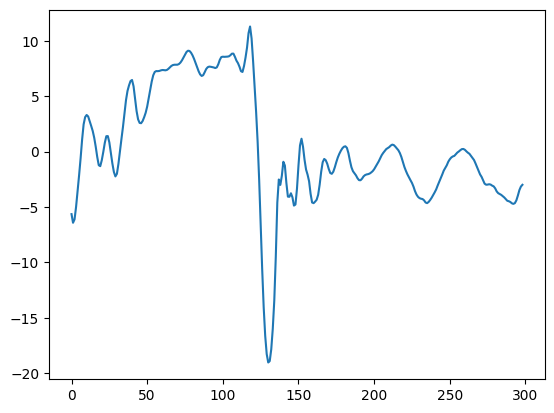

In [14]:
def lrt(row):
    temp_prof = row.Temp
    #plt.plot(temp_prof)

    lr_temp = np.NaN
    lr_height = np.NaN
    temp_prof_1 = temp_prof[1:]
    temp_prof_2 = temp_prof[:-1]
    lr_prof_off_height = -1*(temp_prof_1 - temp_prof_2)/0.1
    lr_prof_off_height_1 = lr_prof_off_height[1:]
    lr_prof_off_height_2 = lr_prof_off_height[:-1]
    lr_prof = np.nanmean([lr_prof_off_height_1, lr_prof_off_height_2], axis=0)
    plt.plot(lr_prof)
    print(np.where(lr_prof <= 2))
    for idx in np.where(lr_prof <= 2)[0]:
        next_2km_avg_lr = np.nanmean(lr_prof[idx:idx+20])
        if next_2km_avg_lr > 2:
            continue
        elif next_2km_avg_lr <= 2:
            lr_temp = temp_prof[idx + 1]
            lr_height = idx/10 + 5.1
            break
    return(lr_temp, lr_height)

RO_df.iloc[4:5].apply(lrt, axis=1, result_type="expand")

In [17]:
def gridder(temp_df):
    lat_vals = np.arange(-90, 90, 2.5)
    lon_vals = np.arange(-180, 180, 2.5)

    cpt_calendar = []
    for month in range(1, 13):
        tempmonth = temp_df[temp_df['Month'] == month]
        cpt_map = []
        for lat_idx in lat_vals:
            lat_df = tempmonth[tempmonth['Latbin'] == lat_idx]
            lat_line_cpt = []
            for lon_idx in lon_vals:
                lon_df = lat_df[lat_df['Lonbin'] == lon_idx]
                if len(lon_df) == 0:
                    cpt = np.NaN
                    cpt_z = np.NaN
                else:
                    cpt = np.nanmean(lon_df.LRT)
                    cpt_z = np.nanmean(lon_df.LRT_z)
                lat_line_cpt.append([cpt, cpt_z])
            cpt_map.append(lat_line_cpt)
        cpt_calendar.append(cpt_map)
    return(cpt_calendar)
    
merged = pd.concat(ROM_SAF_temp_profiles, axis=0)
for year in range(2006, 2022):
    print('Gridding Year: ', year)
    gpsro_full_df_year = merged[merged['Year'] == year]
    cpt_calendar = gridder(gpsro_full_df_year)
    np.save('/usb/cmm_gws/monthlyDryLRT/{year_str}_LRTandLRZGlobal'.format(year_str=str(year)), cpt_calendar)
    #np.save('lrtmaps_{year_str}_c1mamb'.format(year_str=str(year)), lrt_calendar)

Gridding Year:  2006
Gridding Year:  2007
Gridding Year:  2008
Gridding Year:  2009
Gridding Year:  2010
Gridding Year:  2011
Gridding Year:  2012
Gridding Year:  2013
Gridding Year:  2014
Gridding Year:  2015
Gridding Year:  2016
Gridding Year:  2017
Gridding Year:  2018
Gridding Year:  2019
Gridding Year:  2020
Gridding Year:  2021
